<center><div><h1>Markov Stag Hunt</h1></div>

<h3>Expected Utility Theory vs Cumulative Prospect Theory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import pickle
from multiprocessing.dummy import Pool
from itertools import repeat
from scipy.optimize import minimize

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 11}
plt.rc('font', **font)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap='inferno'

# Path to save pickles
path = "pickles"

In [2]:
def total_cum_dist(s_values,s_probs):
    return np.concatenate(([0],np.cumsum(s_probs)[:-1]))

def util_pos(x):
    return x
def util_neg(x):
    return x
def W_approx_pos(k):
    if (k<0).any():
        print('Negative value on W_pos function.')
        print(k)
    return 0.00231*k**0.05 + 0.00128*k**0.1 + 0.19578*k**0.35 + 0.59897*k**0.4 + 0.15968*k**0.95 + 0.03318*k**3 + 0.00847*k**23

def W_approx_neg(k):
    if (k<0).any():
        print('Negative value on W_neg function.')
        print(k)
    return 0.00231*k**0.05 + 0.00128*k**0.1 + 0.19578*k**0.35 + 0.59897*k**0.4 + 0.15968*k**0.95 + 0.03318*k**3 + 0.00847*k**23

def CPT_value(N,P,R,beta,baseline,util_pos,util_neg,W_pos,W_neg,max_iter=150):
    '''Calculates the Cumulative Prospect Theory value (CPT-value) for a given MDP.'''
    # Initialize variables
    value = np.zeros(N)
    value_new = np.zeros(N)
    policy = np.zeros((N,len(P)))
    optimal_values = []
    optimal_policies = []
    
    # Initialize bounds and constraints of optimization
    def constraint(policy): # probabilities must sum to 1
        return np.sum(policy)-1.0

    b = (0.0,1.0)
    bounds = (b,b,b)
    constraints = [{'type':'eq','fun':constraint}]
    p0=np.round(np.ones(len(P))/len(P),10)

    for t in range(max_iter):
        print('[{}/{}]'.format(t+1,max_iter),end='\r')
        
        U_all = np.expand_dims(R,1)+beta*value-baseline
        
        for s in range(N):
            u_pos = util_pos( np.maximum(np.zeros(N),U_all[s]))
            u_neg = util_neg(-np.minimum(np.zeros(N),U_all[s]))
            
            u_pos_sargs = np.argsort(u_pos)
            u_neg_sargs = np.argsort(u_neg)
            
            atoms_u_pos = u_pos[u_pos_sargs]
            atoms_u_neg = u_neg[u_neg_sargs]
            
            zero_atoms_pos = np.concatenate(([0],atoms_u_pos))
            zero_atoms_neg = np.concatenate(([0],atoms_u_neg))
            intervals_pos = zero_atoms_pos[1:]-zero_atoms_pos[:-1]
            intervals_neg = zero_atoms_neg[1:]-zero_atoms_neg[:-1]
            
            Q_pos = np.zeros((len(P),N))
            Q_neg = np.zeros((len(P),N))

            for action,P_a in enumerate(P):
                atoms_Ps_pos = P_a[s][u_pos_sargs]
                atoms_Ps_neg = P_a[s][u_neg_sargs]
                Q_pos[action] = 1-total_cum_dist(atoms_u_pos,atoms_Ps_pos)
                Q_neg[action] = 1-total_cum_dist(atoms_u_neg,atoms_Ps_neg)
                Q_pos[action] = np.maximum(np.zeros_like(Q_pos[action]),Q_pos[action])
                Q_neg[action] = np.maximum(np.zeros_like(Q_neg[action]),Q_neg[action])

            p0=np.round(np.ones(len(P))/len(P),10) if t==0 else optimal_policies[-1][s]
            err_count = 0
            while True:
                
                objective = lambda p:-(W_pos(np.tensordot(Q_pos,p,axes=(0,0)))@intervals_pos-\
                                       W_neg(np.tensordot(Q_neg,p,axes=(0,0)))@intervals_neg)
                solution = minimize(objective,x0=p0,bounds=bounds,constraints=constraints,method='SLSQP')
                
                if solution.success == True:
                    policy[s] = np.round(solution.x,10)
                    value_new[s] = -solution.fun
                    break
                err_count += 1
                p0=np.random.uniform(0,1,size=3); p0[2] = 1 - p0[0] - p0[1];
                print(solution.message,end=' {} \r'.format(err_count))
        
        error = np.sum(np.abs(value_new - value))
        print('[{}/{}] Error: {:.3f} Mag: {:.3f}'.format(t+1,max_iter,error,np.sum(np.abs(value_new))),end='\r')
        value = value_new.copy()
        optimal_values.append(value.copy())
        optimal_policies.append(policy.copy())
    optimal_values = np.array(optimal_values)
    optimal_policies = np.array(optimal_policies)
    return optimal_values,optimal_policies

def choose_best(values,policies):
    optimal_index = np.argmax(np.sum((np.abs(values)),axis=1))
    optimal_value = values[optimal_index]
    optimal_policy = policies[optimal_index]
    return optimal_index,optimal_value,optimal_policy

def get_P1(P_both,policy2):
    return np.einsum('abcd,ca->bcd',P_both,policy2)
def get_P2(P_both,policy1):
    return np.einsum('abcd,cb->acd',P_both,policy1)

def get_markov_chain(P_aa,policy1,policy2):
    return np.einsum('abcd,cb,ca->cd',P_aa,policy1,policy2)
    
def get_agent_density(P_markovchain,time_step,initial_distribution):
    return np.einsum('ij,j->i',
                     np.linalg.matrix_power(P_markovchain.T,time_step),
                     initial_distribution)

def plot_policy(policy):
    f,axes = plt.subplots(1,3,figsize=(15,5))
    titles = ['Pr(Left)','Pr(Stay)','Pr(Right)']
    for i,(ax,title) in enumerate(zip(axes,titles)):
        ax.set_title(title)
        ax.imshow(policy.reshape(N,N,3)[:,:,i].T,origin='lower',cmap=cmap)
        ax.set_xticks(range(N))
        ax.set_yticks(range(N))
        ax.set_xlabel('State of agent 1')
        ax.set_ylabel('State of agent 2')
    plt.tight_layout()
    plt.show()
    
def swap_policy_owner(policy):
    return policy.reshape(N,N,3).transpose(1,0,2).reshape(-1,3)

def plot_density(P_markov_chain,initial_distribution=None,times=[1,10,128]):
    
    initial_distribution = np.ones(N*N)/(N*N)
    f,axes = plt.subplots(1,len(times),figsize=(15,5))
    for ax,t in zip(axes,times):
        ax.set_title('Agent density at time {}'.format(t))
        ax.imshow(get_agent_density(P_markov_chain,t,initial_distribution).reshape(N,N).T,origin='lower',cmap=cmap)
        ax.set_xlabel('State of agent 1')
        ax.set_ylabel('State of agent 2')
        ax.set_xticks(range(16))
        ax.set_yticks(range(16))
    plt.tight_layout()
    plt.show()

    
def plot_equilibrium_density(P_markov_chain,figsize=(10,5),clim=None):
    initial_distribution = np.ones(N*N)/(N*N)
    plt.figure(figsize=figsize)
    plt.title('Agent density at equilibrium')
    plt.imshow(get_agent_density(P_markov_chain,1000,initial_distribution).reshape(N,N).T,origin='lower',cmap=cmap)
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.colorbar()
    if clim!=None:
        plt.clim(*clim)
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.tight_layout()
    plt.show()

In [3]:
N = 16
r = np.zeros(N)

hare_reward = 1
stag_reward = 5

r[3] = hare_reward
r[11] = stag_reward

P_L = np.zeros((N,N))
P_S = np.zeros((N,N))
P_R = np.zeros((N,N))

for i in range(N):
    P_S[i,i]=1
    if i>0:
        P_L[i,i-1]=1
    else:
        P_L[i,i]=1
    if i<N-1:
        P_R[i,i+1]=1
    else:
        P_R[i,i]=1

def add_noise(noise,P_L=P_L,P_S=P_S,P_R=P_R):
    p_L,p_S,p_R = P_L.copy(),P_S.copy(),P_R.copy()
    p_L = (1-noise)*P_L.copy() + noise*(P_S.copy() + P_R.copy())/2
    p_S = (1-noise)*P_S.copy() + noise*(P_L.copy() + P_R.copy())/2
    p_R = (1-noise)*P_R.copy() + noise*(P_S.copy() + P_L.copy())/2
    return p_L,p_S,p_R

P_L,P_S,P_R = add_noise(0.4)

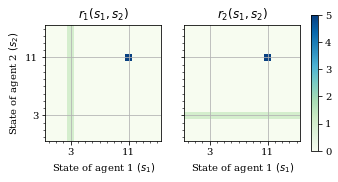

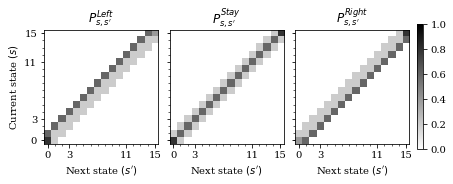

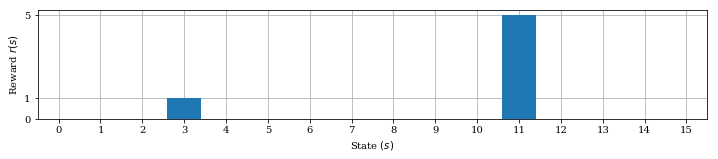

In [4]:
P1 = [np.kron(np.eye(N),P_) for P_ in [P_L,P_S,P_R]]
P2 = [np.kron(P_,np.eye(N)) for P_ in [P_L,P_S,P_R]]
P_both = [[(p1+p2)/2 for p2 in P2] for p1 in P1] # [a1,a2,s,s']

R1 = np.zeros((N,N))
R1[3,:] = hare_reward
R1[11,11] = stag_reward
R1=R1.flatten()
R2 = np.zeros((N,N))
R2[:,3] = hare_reward
R2[11,11] = stag_reward
R2=R2.flatten()

beta=0.9
baseline=0
max_iter=100

f,axes = plt.subplots(1,2,figsize=(5,2.5),sharey=True)
ax1,ax2=axes
ax=ax1
ax.imshow(R1.reshape(N,N).T,cmap='GnBu',origin='lower')
ax.set_xlabel(r'State of agent 1 $(s_1)$')
ax.set_ylabel(r'State of agent 2 $(s_2)$')

ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_xticks([3,11], minor=False)
ax.xaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.xaxis.grid(False, which='minor')
ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_yticks([3,11], minor=False)
ax.yaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.yaxis.grid(False, which='minor')

ax.set_title(r'$r_1(s_1,s_2)$')

ax=ax2
im = ax.imshow(R2.reshape(N,N).T,cmap='GnBu',origin='lower')
ax.set_xlabel(r'State of agent 1 $(s_1)$')

ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_xticks([3,11], minor=False)
ax.xaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.xaxis.grid(False, which='minor')
ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_yticks([3,11], minor=False)
ax.yaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.yaxis.grid(False, which='minor')

ax.set_title(r'$r_2(s_1,s_2)$')
plt.colorbar(im,ax=axes.ravel(),fraction=0.046, pad=0.04)
# plt.savefig('reward_functions.pdf')
plt.show()

f,axes = plt.subplots(1,3,figsize=(7,2.3),sharey=True)
ax1,ax2,ax3=axes
ax1.imshow(P_L,cmap='binary',origin='lower',vmin=0, vmax=1)
ax1.set_title(r"$P^{Left}_{s,s'}$")
im2 = ax2.imshow(P_S,cmap='binary',origin='lower',vmin=0, vmax=1)
ax2.set_title(r"$P^{Stay}_{s,s'}$")
im3 = ax3.imshow(P_R,cmap='binary',origin='lower',vmin=0, vmax=1)
ax3.set_title(r"$P^{Right}_{s,s'}$")

ax1.set_xlabel(r"Next state $(s')$")
ax2.set_xlabel(r"Next state $(s')$")
ax3.set_xlabel(r"Next state $(s')$")
ax1.set_ylabel(r'Current state $(s)$')

ax1.set_xticks(range(N))
ax2.set_xticks(range(N))
ax3.set_xticks(range(N))
ax1.set_yticks(range(N))
ax2.set_yticks(range(N))
ax3.set_yticks(range(N))
for ax in axes:
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([0,3,11,15], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([0,3,11,15], minor=False)

plt.subplots_adjust(wspace=0.1,hspace=1)
f.colorbar(im3, ax=axes.ravel().tolist(),fraction=0.045, pad=0.02)
# plt.savefig('transition_probabilities.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,2))
plt.bar(range(N),r,zorder=10)
plt.xticks(range(N))
plt.xlim(-0.5,15.5)
plt.xlabel(r'State $(s)$')
plt.yticks([0,hare_reward,stag_reward])
plt.ylabel(r'Reward $r(s)$')
plt.grid()
# plt.savefig('rewardMDP.pdf',bbox_inches='tight')

plt.show()

<center><h1>Results - Expected Utility Theory

policy sums to 1? True Mag: 573.041


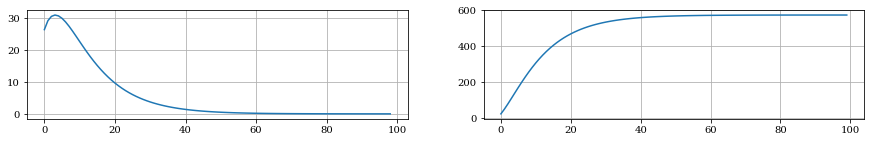

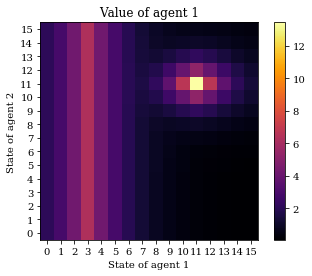

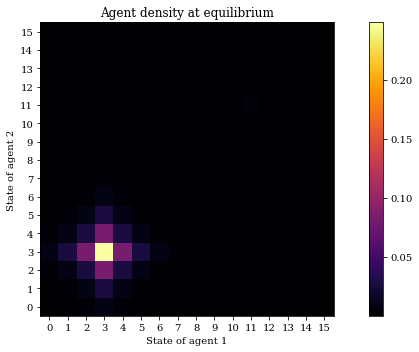

policy sums to 1? True Mag: 829.520


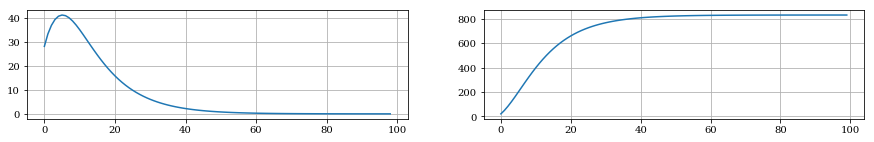

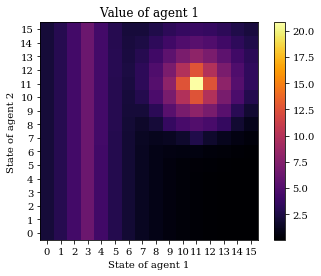

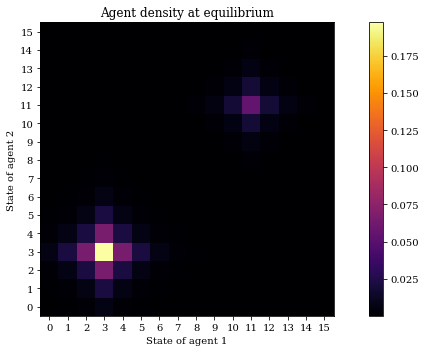

policy sums to 1? True Mag: 864.272


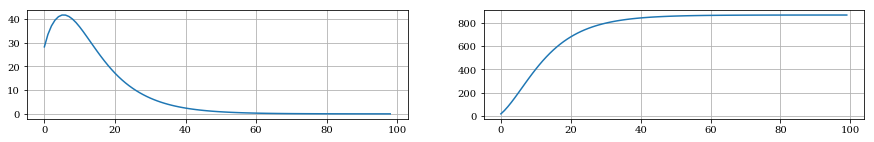

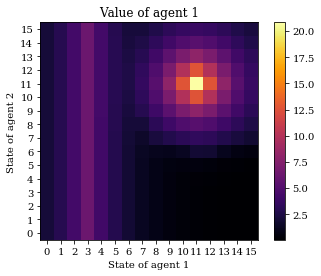

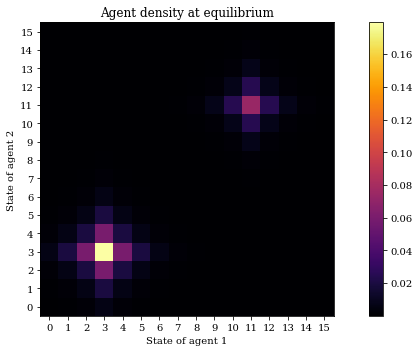

policy sums to 1? True Mag: 869.669


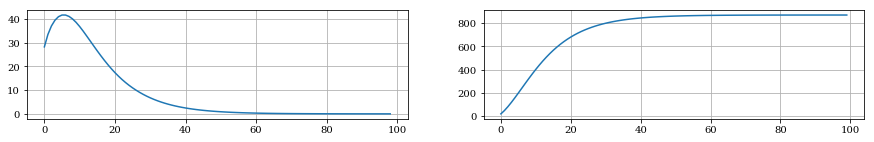

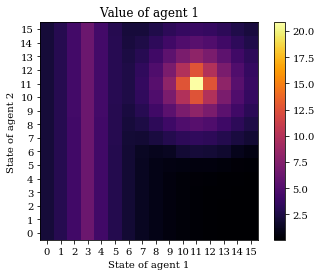

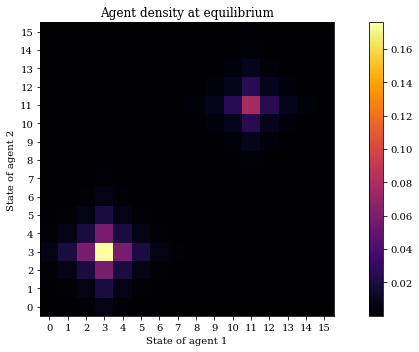

policy sums to 1? True Mag: 871.043


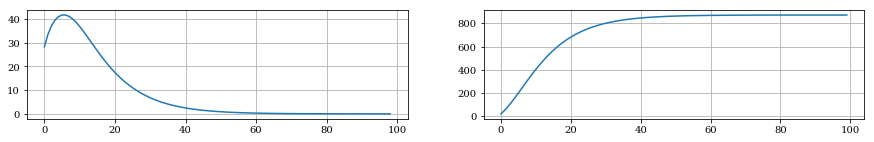

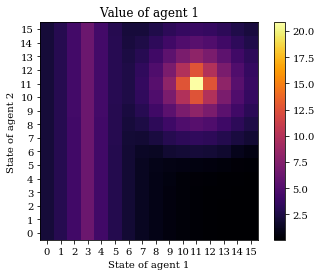

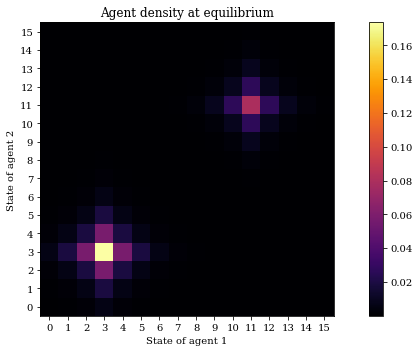

In [5]:
random_policy = np.ones((N*N,3))/3

EUT_k_pols = []
EUT_k_vals = []
EUT_k_opt_pols = []
EUT_k_opt_vals = []

for k in range(5):
    baseline_policy = random_policy if len(EUT_k_opt_pols)==0 else EUT_k_opt_pols[-1].copy()
    transformed_P1 = get_P1(P_both,swap_policy_owner(baseline_policy))
    vals, pols = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=0,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=lambda x:x,
                           W_neg=lambda x:x,
                           max_iter=max_iter)
    _,opt_val,opt_pol = choose_best(vals,pols)
    EUT_k_pols.append(pols)
    EUT_k_vals.append(vals)
    EUT_k_opt_pols.append(opt_pol)
    EUT_k_opt_vals.append(opt_val)

    errors = np.sum(np.abs(vals[1:]-vals[:-1]),axis=1)
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(15,2))
    ax1.plot(errors)
    ax1.grid()
    ax2.plot(np.sum(np.abs(vals),axis=1))
    ax2.grid()
    plt.show()

    plt.figure()
    plt.title('Value of agent 1')
    plt.imshow(opt_val.reshape(N,N).T,cmap=cmap,origin='lower')
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.colorbar()
    plt.show()

    q = get_markov_chain(P_both,opt_pol,swap_policy_owner(opt_pol))
    plot_equilibrium_density(q)

In [6]:
pickle.dump(EUT_k_pols,    open(path+'/EUT/EUT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_vals,    open(path+'/EUT/EUT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_opt_pols,open(path+'/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_opt_vals,open(path+'/EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))

<center><h1>Results - Cumulative Prospect Theory

0


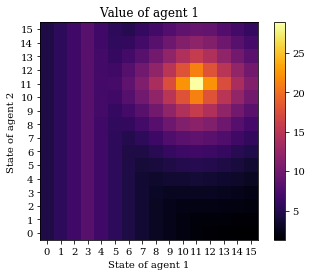

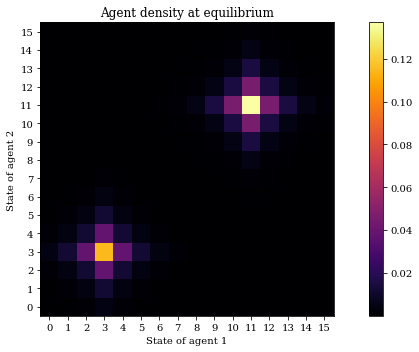

1


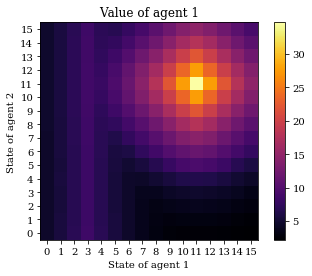

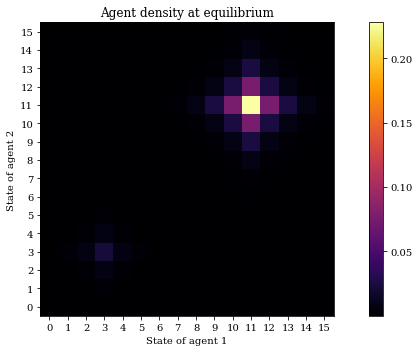

2


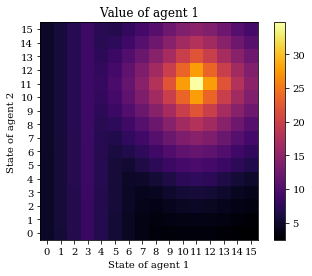

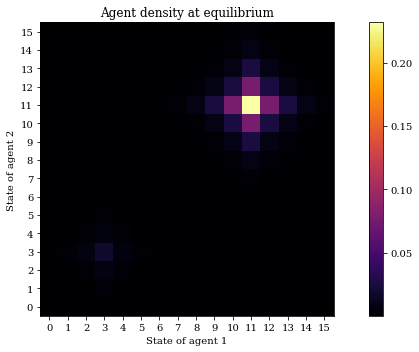

3


d:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
d:\program files\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


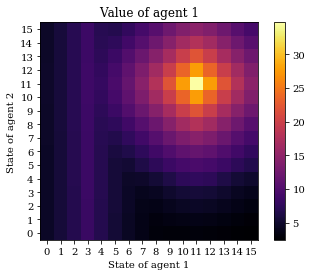

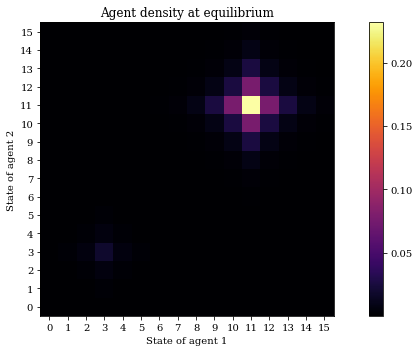

4


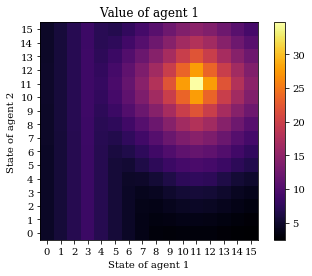

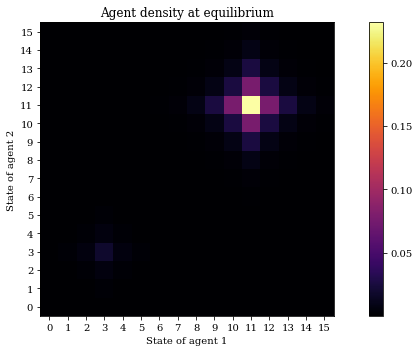

In [7]:
random_policy = np.ones((N*N,3))/3

CPT_k_pols = []
CPT_k_vals = []

CPT_k_opt_pols = []
CPT_k_opt_vals = []

for k in range(5):
    print(k)
    baseline_policy = random_policy if len(CPT_k_opt_pols)==0 else CPT_k_opt_pols[-1].copy()
    transformed_P1 = get_P1(P_both,swap_policy_owner(baseline_policy))
    vals, pols = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=W_approx_pos,
                           W_neg=W_approx_neg,
                           max_iter=max_iter)
    _,opt_val,opt_pol = choose_best(vals,pols)
    CPT_k_pols.append(pols)
    CPT_k_vals.append(vals)
    CPT_k_opt_pols.append(opt_pol)
    CPT_k_opt_vals.append(opt_val)

    plt.figure()
    plt.title('Value of agent 1')
    plt.imshow(opt_val.reshape(N,N).T,cmap=cmap,origin='lower')
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.colorbar()
    plt.show()

    q = get_markov_chain(P_both,opt_pol,swap_policy_owner(opt_pol))
    plot_equilibrium_density(q)


In [8]:
pickle.dump(CPT_k_pols,    open(path+'/CPT/CPT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_vals,    open(path+'/CPT/CPT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_opt_pols,open(path+'/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_opt_vals,open(path+'/CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))

<h3><center> Load Pickles if already run

In [9]:
EUT_k_pols     = pickle.load(open(path+'./EUT/EUT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_vals     = pickle.load(open(path+'./EUT/EUT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_opt_pols = pickle.load(open(path+'./EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_opt_vals = pickle.load(open(path+'./EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

CPT_k_pols     = pickle.load(open(path+'./CPT/CPT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_vals     = pickle.load(open(path+'./CPT/CPT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_opt_pols = pickle.load(open(path+'./CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_opt_vals = pickle.load(open(path+'./CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

<h1><center>Create Figures

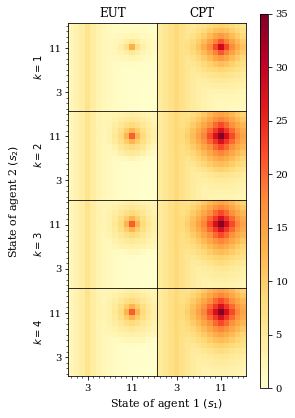

In [10]:
A_opt_vals = pickle.load(open('./REDONE/pickles/EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
B_opt_vals = pickle.load(open('./REDONE/pickles/CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

N_opt_vals = [A_opt_vals,B_opt_vals]
N_titles   = ["EUT","CPT"]

vmax=np.max(np.concatenate((N_opt_vals)))

# ---------------------------------------------------------------------------------------

fig, axes = plt.subplots(4,len(N_opt_vals),figsize=(7.4/2,6.5),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break

    for i,(a,d) in enumerate(zip(ax,np.array(N_opt_vals).transpose(1,0,2)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='YlOrRd',origin='lower',vmin=0,vmax=35)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=-.015,right=0.8)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(-0.1, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig('values.pdf'.format(k+1),bbox_inches='tight')
plt.show()

<h1><center> Discount Factor Sensitivity

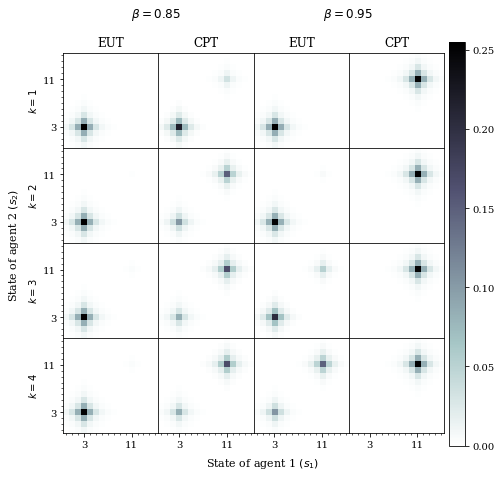

In [12]:
A_opt_pols = pickle.load(open('./discountFactor .85/pickles/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
B_opt_pols = pickle.load(open('./discountFactor .85/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

C_opt_pols = pickle.load(open('./discountFactor .95/pickles/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
D_opt_pols = pickle.load(open('./discountFactor .95/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

N_opt_pols = [A_opt_pols,B_opt_pols,C_opt_pols,D_opt_pols]
N_titles   = ["EUT","CPT","EUT","CPT"]
N_densities = []
for opt_pols in N_opt_pols:
    densities = []
    for k,pol in enumerate(opt_pols):
#         print(k)
        q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
        density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
        densities.append(density)
        densities[k]=densities[k]/np.sum(densities[k])
    N_densities.append(densities)
    
vmax=np.max(np.concatenate((N_densities)))
vmax

# ---------------------------------------------------------------------------------------

fig, axes = plt.subplots(4,len(N_densities),figsize=(7.4,7),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break
    
    for i,(a,d) in enumerate(zip(ax,np.array(N_densities).transpose(1,0,2,3)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=0,right=0.84)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

fig.text(0.3, 0.95, r"$\beta=0.85$", fontsize=12,rotation="horizontal",horizontalalignment="center")
fig.text(0.66, 0.95, r"$\beta=0.95$", fontsize=12,rotation="horizontal",horizontalalignment="center")

plt.savefig('rf_densitiesV2.pdf'.format(k+1),bbox_inches='tight')
plt.show()

In [13]:
EUT_k_densities = []
for k,pol in enumerate(EUT_k_opt_pols):
    q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
    density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
    EUT_k_densities.append(density)
    EUT_k_densities[k]=EUT_k_densities[k]/np.sum(EUT_k_densities[k])

CPT_k_densities = []
for k,pol in enumerate(CPT_k_opt_pols):
    q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
    density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
    CPT_k_densities.append(density)
    CPT_k_densities[k]=CPT_k_densities[k]/np.sum(CPT_k_densities[k])
vmax=np.max(np.concatenate((CPT_k_densities,EUT_k_densities)))

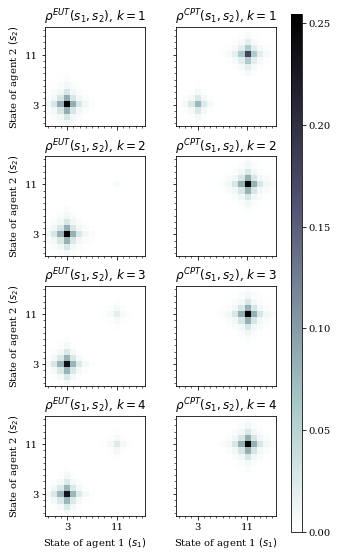

In [14]:

fig, axes = plt.subplots(4,2,figsize=(5,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,((ax_EUT,ax_CPT),density_EUT,density_CPT) in enumerate(zip(axes,EUT_k_densities,CPT_k_densities)):
    if k==4:
        break

    im = ax_EUT.imshow(density_EUT.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
    im = ax_CPT.imshow(density_CPT.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
    
    if k==3:
        ax_EUT.set_xlabel(r'State of agent 1 $(s_1)$')
        ax_CPT.set_xlabel(r'State of agent 1 $(s_1)$')
    ax_EUT.set_ylabel(r'State of agent 2 $(s_2)$')
    
    ax_EUT.set_title(r'$\rho^{{EUT}}(s_1,s_2)$, $k={}$'.format(k+1))
    ax_CPT.set_title(r'$\rho^{{CPT}}(s_1,s_2)$, $k={}$'.format(k+1))

fig.subplots_adjust(hspace=0.3,wspace=0,right=0.85)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('densities.pdf'.format(k+1),bbox_inches='tight')
plt.show()

<h1><center> Reference Point Sensitivity

In [15]:
rp_n1_k_opt_pols = pickle.load(open('./referencePoint -1/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_0_opt_pols    = pickle.load(open('./referencePoint 0/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_1_opt_pols    = pickle.load(open('./referencePoint +1/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_2_opt_pols    = pickle.load(open('./referencePoint +2/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

In [16]:
N_opt_pols = [rp_n1_k_opt_pols,rp_0_opt_pols,rp_1_opt_pols,rp_2_opt_pols]
N_titles   = [r"$b=-1$",r"$b=0$",r"$b=1$",r"$b=2$"]
N_densities = []
for opt_pols in N_opt_pols:
    densities = []
    for k,pol in enumerate(opt_pols):
        q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
        density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
        densities.append(density)
        densities[k]=densities[k]/np.sum(densities[k])
    N_densities.append(densities)
    
vmax=np.max(np.concatenate((N_densities)))

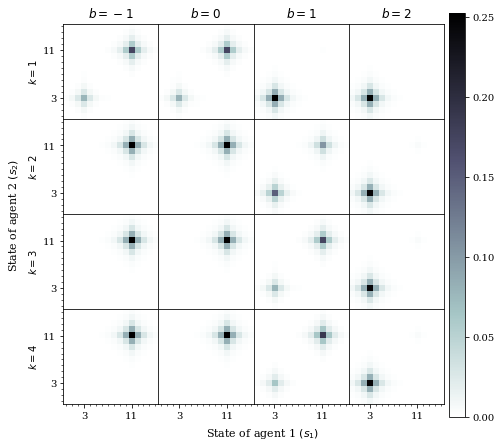

In [17]:
fig, axes = plt.subplots(4,len(N_densities),figsize=(7.4,7),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break
    
    for i,(a,d) in enumerate(zip(ax,np.array(N_densities).transpose(1,0,2,3)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=0,right=0.84)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig('rp_densities.pdf'.format(k+1),bbox_inches='tight')
plt.show()